You are absolutely right. My apologies for making you piece it together. That was confusing.

Here is the **complete, final notebook** from start to finish. This single file contains all the upgrades we discussed:

1.  **More Data** (20,000 samples)
2.  **Bidirectional Encoder** (for better context)
3.  **Upgraded Decoder** (to match the encoder)
4.  **Dropout** (to fight overfitting)
5.  **EarlyStopping** (to get the best model automatically)
6.  The **correctly placed** `model.compile()` cell
7.  The **plotting cell** to see the results
8.  The **fixed inference models** that work with the new architecture

Just copy and paste each cell into Google Colab one by one. This will work.

-----

### **Text Cell**

# 🧠 FDP Day 4 (V2): Upgraded Spanish Translation

This is the complete, upgraded notebook for Spanish translation.

We will implement three professional techniques to build a much better model:

1.  **More Data:** We'll use 20,000 samples instead of 10,000.
2.  **A Bidirectional Encoder:** Our encoder will now read the English sentence both forwards and backwards, giving it a much deeper understanding of the context.
3.  **Regularization:** We'll add `Dropout` and `EarlyStopping` to prevent overfitting and get the best possible result.

-----

### **Code Cell 1: Imports**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, GRU, Dense, Bidirectional, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

print("Libraries imported (including Bidirectional, Dropout, and EarlyStopping).")

Libraries imported (including Bidirectional, Dropout, and EarlyStopping).


-----

### **Code Cell 2: Parameters**

In [2]:
# --- Parameters ---
BATCH_SIZE = 128          # <-- Increased for faster, more stable training
EPOCHS = 50               # <-- We'll use EarlyStopping, 50 is just a max
LATENT_DIM = 256          # This is the "size" of the thought vector
NUM_SAMPLES = 20000       # <-- INCREASED: More data to fight overfitting!

# --- Data Path ---
DATA_PATH = "spa.txt"

-----

### **Code Cell 3: Download Data**

In [3]:
# Download the data
!curl -O http://www.manythings.org/anki/spa-eng.zip
!unzip -o spa-eng.zip

print("Spanish data downloaded and unzipped.")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5338k  100 5338k    0     0  8027k      0 --:--:-- --:--:-- --:--:-- 8027k
Archive:  spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 
Spanish data downloaded and unzipped.


-----

### **Code Cell 4: Parse Data**

In [4]:
# --- Parse the data --
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

# Read the file
with open(DATA_PATH, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

# Process each line
for line in lines[: min(NUM_SAMPLES, len(lines) - 1)]:
    # Split the line into English (input) and Spanish (target)
    try:
        input_text, target_text, _ = line.split("\t")
    except:
        print(f"Skipping bad line: {line}")
        continue

    # We use "tab" as the "start sequence" token
    # and "\n" as the "end sequence" token for the target.
    target_text = "\t" + target_text + "\n"

    input_texts.append(input_text)
    target_texts.append(target_text)

    # Add any new characters to our "vocabulary" sets
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

print(f"Loaded {len(input_texts)} sentence pairs.")

Loaded 20000 sentence pairs.


-----

### **Code Cell 5: Inspect Data**

In [5]:
print("--- 10 Sample Pairs ---")
for i in range(10):
    print(f"Input:    {input_texts[i]}")
    # We use repr() to show the "hidden" \t and \n characters
    print(f"Target:   {repr(target_texts[i])}")
    print("---")

--- 10 Sample Pairs ---
Input:    Go.
Target:   '\tVe.\n'
---
Input:    Go.
Target:   '\tVete.\n'
---
Input:    Go.
Target:   '\tVaya.\n'
---
Input:    Go.
Target:   '\tVáyase.\n'
---
Input:    Hi.
Target:   '\tHola.\n'
---
Input:    Run!
Target:   '\t¡Corre!\n'
---
Input:    Run!
Target:   '\t¡Corran!\n'
---
Input:    Run!
Target:   '\t¡Huye!\n'
---
Input:    Run!
Target:   '\t¡Corra!\n'
---
Input:    Run!
Target:   '\t¡Corred!\n'
---


-----

### **Code Cell 6: Create Vocabularies**

In [6]:
# Sort the vocabularies
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))

# Get the size of our vocabularies and longest sentences
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("\n--- Data Stats ---")
print("Number of unique input tokens (English characters):", num_encoder_tokens)
print("Number of unique output tokens (Spanish characters):", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)


--- Data Stats ---
Number of unique input tokens (English characters): 72
Number of unique output tokens (Spanish characters): 86
Max sequence length for inputs: 18
Max sequence length for outputs: 49


-----

### **Code Cell 7: Create Index Maps**

In [7]:
# Create the character-to-index lookup maps
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

print("--- Input Token Index (English) ---")
print(list(input_token_index.items())[:15])

print("\n--- Target Token Index (Spanish) ---")
print(list(target_token_index.items())[:15])

--- Input Token Index (English) ---
[(' ', 0), ('!', 1), ('"', 2), ('$', 3), ('&', 4), ("'", 5), (',', 6), ('-', 7), ('.', 8), ('0', 9), ('1', 10), ('2', 11), ('3', 12), ('4', 13), ('5', 14)]

--- Target Token Index (Spanish) ---
[('\t', 0), ('\n', 1), (' ', 2), ('!', 3), ('"', 4), ('&', 5), ("'", 6), (',', 7), ('-', 8), ('.', 9), ('0', 10), ('1', 11), ('2', 12), ('3', 13), ('4', 14)]


-----

### **Text Cell**

## Cell 8: Vectorization (One-Hot Encoding)

This is the most important pre-processing step. We create three massive 3D arrays to hold our data. We are using **Teacher Forcing**, which is why we create `decoder_input_data` (the "question," e.g., `\tH_o_l_a`) and `decoder_target_data` (the "answer," e.g., `H_o_l_a_\n`).

-----

### **Code Cell 9: Vectorization**

In [8]:
# --- Create the empty numpy arrays ---
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

print("Created empty data arrays...")

# --- Fill the arrays with one-hot vectors ---
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    # Fill encoder_input_data
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    # Pad the rest of the sequence with spaces
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0

    # Fill decoder_input_data and decoder_target_data
    for t, char in enumerate(target_text):
        # decoder_input_data is the sequence itself
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data is the sequence shifted by one
            # (it does not include the start token '\t')
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    # Pad the rest of the sequences with spaces
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

print("Data vectorization (one-hot encoding) complete.")
print(f"Shape of encoder_input_data: {encoder_input_data.shape}")
print(f"Shape of decoder_input_data: {decoder_input_data.shape}")
print(f"Shape of decoder_target_data: {decoder_target_data.shape}")

Created empty data arrays...
Data vectorization (one-hot encoding) complete.
Shape of encoder_input_data: (20000, 18, 72)
Shape of decoder_input_data: (20000, 49, 86)
Shape of decoder_target_data: (20000, 49, 86)


-----

### **Text Cell**

## Cell 10: Define the **Upgraded** Encoder

Here we use a `Bidirectional` GRU. This reads the input sentence both forwards and backwards and concatenates its final states. This creates a much richer "thought vector" (now 512 dimensions).

-----

### **Code Cell 11: The Encoder**

In [9]:
# --- Encoder ---
# Define the input layer
encoder_inputs = Input(shape=(None, num_encoder_tokens))

# --- NEW: Bidirectional GRU ---
# This layer reads the sequence forwards AND backwards
# We add recurrent_dropout to prevent overfitting
encoder_gru = Bidirectional(
    GRU(LATENT_DIM, return_state=True, reset_after=False, recurrent_dropout=0.2)
)

# It returns 3 things: outputs, forward_state, and backward_state
encoder_outputs, forward_h, backward_h = encoder_gru(encoder_inputs)

# --- NEW: Concatenate States ---
# We combine the forward and backward states into one
# This makes our "thought vector" twice as big (256 + 256 = 512)
state_h = concatenate([forward_h, backward_h])

# This is our final, double-sized context vector
encoder_states = [state_h]

print("Bidirectional Encoder built.")
print(f"Original LATENT_DIM: {LATENT_DIM}")
print(f"Concatenated state shape will be: {LATENT_DIM * 2}")

Bidirectional Encoder built.
Original LATENT_DIM: 256
Concatenated state shape will be: 512


-----

### **Text Cell**

## Cell 12: Define the **Upgraded** Decoder

To match the encoder's new 512-dim state, the decoder's GRU must also have 512 units. We also add `Dropout` for regularization.

-----

### **Code Cell 13: The Decoder**

In [10]:
# --- Decoder ---
# Define the input layer
decoder_inputs = Input(shape=(None, num_decoder_tokens))

# --- NEW: Decoder DIM must match Encoder's combined state ---
# We set the decoder's GRU units to LATENT_DIM * 2 (which is 512)
DECODER_DIM = LATENT_DIM * 2

# We also add recurrent_dropout here
decoder_gru = GRU(DECODER_DIM, return_sequences=True, return_state=True, reset_after=False, recurrent_dropout=0.2)

# Run the inputs through the GRU, using the ENCODER'S combined state
decoder_outputs, _ = decoder_gru(decoder_inputs, initial_state=encoder_states)

# --- NEW: Add a Dropout layer for regularization ---
decoder_outputs = Dropout(0.2)(decoder_outputs)

# A Dense layer to act as our character-classifier
decoder_dense = Dense(num_decoder_tokens, activation="softmax")

# Apply the classifier to the GRU's outputs
decoder_outputs = decoder_dense(decoder_outputs)

print("Decoder built to match Bidirectional Encoder (512 units).")

Decoder built to match Bidirectional Encoder (512 units).


-----

### **Text Cell**

## Cell 14: Define and Compile the **Training** Model

This is the crucial step that connects the encoder and decoder into the final `model` that we will train.

-----

### **Code Cell 15: Build & Compile Model**

In [11]:
# --- Full Model ---
# This is the model we will *train*. It connects the new
# Bidirectional Encoder and the 512-unit Decoder.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
# We use 'rmsprop' for the first phase of training
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)

print("Model compiled.")
model.summary()

Model compiled.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 72)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ [(None, 512),     │    505,344 │ input_layer[0][0] │
│ (Bidirectional)     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None, 86)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ [(None, None,     │    920,064 │ input_layer_1[0]… │
│                     │ 512), (None,      │            │ concatenate[0][0] │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, None, 512) │          0 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None, 86)  │     44,118 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,469,526 (5.61 MB)

 Trainable params: 1,469,526 (5.61 MB)

 Non-trainable params: 0 (0.00 B)

-----

### **Text Cell**

## Cell 16: Train the Model (with Early Stopping)

We now train the model. We add an `EarlyStopping` callback to monitor the `val_loss`. This will automatically stop training when the model stops improving, giving us the best possible version and preventing overfitting.

-----

### **Code Cell 17: Training**

In [12]:
print("Starting model training with Early Stopping...")

# --- NEW: Add EarlyStopping ---
# This will stop training automatically when validation loss stops improving
# It also restores the weights from the *best* epoch
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    [encoder_input_data, decoder_input_data], # Pass both inputs
    decoder_target_data,                      # Pass the target
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping]                # <-- Pass in the callback
)

print("\nTraining complete (or stopped early).")
# Save the model
model.save("seq2seq_spanish_translator_v2.keras")
print("Model saved.")

Starting model training with Early Stopping...
Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.6567 - loss: 1.7923 - val_accuracy: 0.6590 - val_loss: 1.2890
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.7193 - loss: 1.0359 - val_accuracy: 0.6873 - val_loss: 1.0414
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.7501 - loss: 0.8672 - val_accuracy: 0.7236 - val_loss: 0.9371
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.7697 - loss: 0.7790 - val_accuracy: 0.7350 - val_loss: 0.8840
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.7775 - loss: 0.7454 - val_accuracy: 0.7316 - val_loss: 0.8735
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.7819 - loss: 0.7248 - val_accuracy: 0.7430 - val_loss: 0.8399
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.7856 - loss: 0.7070 - val_accuracy: 0.7428 - val_loss: 0.8301
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/s

-----

### **Code Cell 18: Plot Training History**

Plotting training and validation history...


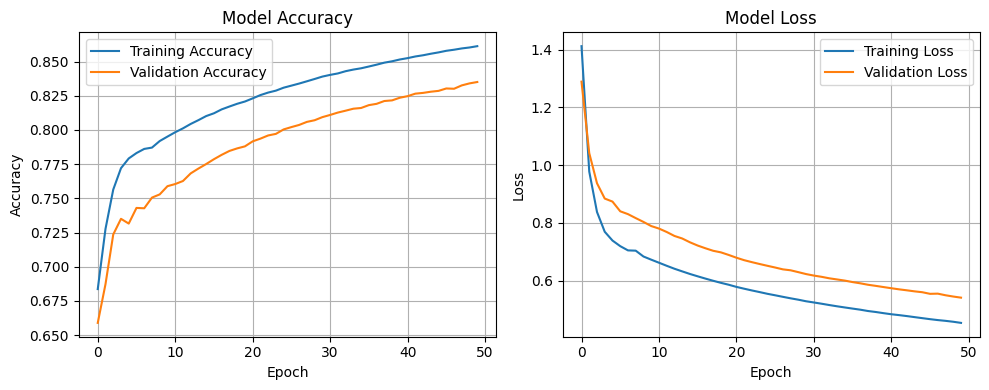

In [13]:
# --- NEW: Plot the training history ---
print("Plotting training and validation history...")

history_df = pd.DataFrame(history.history)

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

-----

### **Text Cell**

## Cell 19: Building the Inference Models

Training is done\! Now we rebuild the model for *actual translation*. We need two separate models: one to create the "thought vector" and one to decode it one character at a time.

-----

### **Code Cell 20: Inference Encoder**

In [14]:
# We create a new model that just runs the encoder
encoder_model = Model(encoder_inputs, encoder_states)

print("Encoder (Inference) Model built.")
encoder_model.summary()

Encoder (Inference) Model built.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 72)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ [(None, 512),     │    505,344 │ input_layer[0][0] │
│ (Bidirectional)     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 505,344 (1.93 MB)

 Trainable params: 505,344 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

-----

### **Code Cell 21: Inference Decoder (FIXED)**

This is the **fixed** inference decoder. The `decoder_state_input_h` is now set to `Input(shape=(LATENT_DIM * 2,))` to accept the 512-dimension state from our bidirectional encoder.

In [15]:
# --- Decoder (Inference) ---

# --- FIX: The state input must now be LATENT_DIM * 2 (i.e., 512) ---
decoder_state_input_h = Input(shape=(LATENT_DIM * 2,))
decoder_states_inputs = [decoder_state_input_h]

# We need a new input for the single character
decoder_inputs_single_step = Input(shape=(1, num_decoder_tokens))

# We use the *original* GRU layer (decoder_gru from Cell 13)
# which is already set to 512 units.
decoder_outputs, state_h_dec = decoder_gru(
    decoder_inputs_single_step, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec]

# We use the *original* dense layer
decoder_outputs = decoder_dense(decoder_outputs)

# This is our final inference-mode decoder
decoder_model = Model(
    [decoder_inputs_single_step] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

print("Decoder (Inference) Model built.")
decoder_model.summary()

Decoder (Inference) Model built.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 1, 86)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ [(None, 1, 512),  │    920,064 │ input_layer_3[0]… │
│                     │ (None, 512)]      │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 86)     │     44,118 │ gru_1[1][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 964,182 (3.68 MB)

 Trainable params: 964,182 (3.68 MB)

 Non-trainable params: 0 (0.00 B)

-----

### **Code Cell 22: Decode Function**

In [16]:
# --- Setup reverse lookup ---
# We need to go from index-back-to-character to read the output
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

print("Reverse lookup dictionaries created.")


def decode_sequence(input_seq):
    # 1. ENCODE: Run the input sentence through the encoder
    # This gives us the "thought vector" (states_value)
    states_value = encoder_model.predict(input_seq, verbose=0)

    # 2. START: Create a 1-character-long "target" sequence
    # This character is the "start" token ('\t')
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # 3. LOOP: Start our translation loop
    stop_condition = False
    decoded_sentence = ""

    while not stop_condition:
        # 4. PREDICT: Feed the current token and the state into the decoder
        output_tokens, h = decoder_model.predict([target_seq] + [states_value], verbose=0)

        # 5. SAMPLE: Find the most likely next character (the one with the highest prob)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]

        # 6. APPEND: Add the new character to our sentence
        decoded_sentence += sampled_char

        # 7. CHECK: Stop if we hit the "end" token ('\n') or the max length
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # 8. UPDATE: Prepare for the next loop
        # The new "current token" is the character we just predicted
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # The new "state" is the state `h` that the decoder just returned
        states_value = h

    return decoded_sentence

print("\nDecode function created.")

Reverse lookup dictionaries created.

Decode function created.


-----

### **Code Cell 23: Test on Training Samples**

In [17]:
# --- Test the model on 20 samples ---
for seq_index in range(0, 200, 10): # Take 20 samples from the set
    # Take one sequence
    input_seq = encoder_input_data[seq_index : seq_index + 1]

    # Run our function
    decoded_sentence = decode_sequence(input_seq)

    print("-" * 30)
    print(f"Sample #{seq_index}")
    print(f"Input:    {input_texts[seq_index]}")
    # .strip() removes the \t and \n for clean viewing
    print(f"Actual:   {target_texts[seq_index].strip()}")
    print(f"Predicted: {decoded_sentence.strip()}")

------------------------------
Sample #0
Input:    Go.
Actual:   Ve.
Predicted: ¡Vete!
------------------------------
Sample #10
Input:    Run.
Actual:   Corra.
Predicted: ¡Pregunte!
------------------------------
Sample #20
Input:    Fire!
Actual:   ¡Incendio!
Predicted: ¡Está para de Tom?
------------------------------
Sample #30
Input:    Stay.
Actual:   Quédese.
Predicted: Espera esto.
------------------------------
Sample #40
Input:    Wait.
Actual:   Espera.
Predicted: Espera esto.
------------------------------
Sample #50
Input:    Hurry!
Actual:   ¡Daos prisa!
Predicted: ¡Aprenda!
------------------------------
Sample #60
Input:    I won!
Actual:   ¡He ganado yo!
Predicted: ¡Estoy aquí!
------------------------------
Sample #70
Input:    Shoot!
Actual:   ¡Dispare!
Predicted: ¡Qué aquí!
------------------------------
Sample #80
Input:    Eat it.
Actual:   Cómetelo.
Predicted: Espera.
------------------------------
Sample #90
Input:    Go now.
Actual:   Ve ahora mismo.
Predicted:

-----

### **Code Cell 24: Test Your Own Sentences**

In [18]:
def translate_sentence(input_text):
    print(f"Translating: '{input_text}'")

    # 1. Create the empty input array
    input_seq = np.zeros(
        (1, max_encoder_seq_length, num_encoder_tokens), dtype="float32"
    )

    # 2. Fill it with one-hot vectors for the input text
    for t, char in enumerate(input_text):
        if char in input_token_index:
            input_seq[0, t, input_token_index[char]] = 1.0
        else:
            print(f"Warning: Unknown character '{char}' skipped.")

    # Pad the rest with spaces
    input_seq[0, t + 1 :, input_token_index[" "]] = 1.0

    # 3. Decode the sequence
    decoded_sentence = decode_sequence(input_seq)

    print(f"Spanish:   {decoded_sentence.strip()}")


# --- Try it out! ---
translate_sentence("How are you?")
print("-" * 30)
translate_sentence("I love you.")
print("-" * 30)
translate_sentence("Stop!")
print("-" * 30)
translate_sentence("Run.")

Translating: 'How are you?'
Spanish:   ¿Qué tan a la cala?
------------------------------
Translating: 'I love you.'
Spanish:   Me gusta el calio.
------------------------------
Translating: 'Stop!'
Spanish:   ¡Deja de aquí!
------------------------------
Translating: 'Run.'
Spanish:   ¡Pregunte!
